# GPU
本节讨论如何使用`GPU`。首先如何使用单个`GPU`，然后是如何使用多个`GPU`和多个服务器（具有多个GPU）。


In [1]:
!nvidia-smi

Fri Nov 15 20:47:24 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.256.02   Driver Version: 470.256.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN RTX    Off  | 00000000:18:00.0 Off |                  N/A |
| 41%   31C    P8     9W / 280W |      6MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN RTX    Off  | 00000000:3B:00.0 Off |                  N/A |
| 41%   

## 计算设备
我们可以指定用于存储和计算的设备。默认情况下，张量是在内存中创建，然后使用CPU去计算他。

在Pytorch中，CPU和GPU可以用`torch.device('cpu')`和`torch.device('cuda')`表示。应该注意的是，`CPU`设备意味着所有的物理CPU和内存，这意味着Pytorch计算将尝试使用所有的CPU核心。然而，`gpu`设备只代表一个卡和相应的显存。如果有多个GPU，我们使用`torch.device(f'cuda:{i}')`来表示第 $i$ 块GPU($i$ 从零开始)。另外, `cuda:0`和`cuda`是等价的。

In [2]:
import torch
from torch import nn

torch.device('cpu'), torch.device('cuda'), torch.device('cuda:1')

(device(type='cpu'), device(type='cuda'), device(type='cuda', index=1))

我们可以查询GPU的数量。

In [3]:
torch.cuda.device_count()

2

现在定义两个方便的函数，这两个函数允许我们在不存在所需的所有GPU的情况下运行代码。

In [5]:
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0), device(type='cuda', index=1)])

## 张量与GPU
默认情况下，张量是在CPU上创建

In [6]:
x = torch.tensor([1,2,3])
x.device

device(type='cpu')

需要注意的是，无论何时我们要对多个项目进行操作，他们都必须在同一个设备上。例如，如果我们对两个张量求和，我们需要确保两个张量都在同一个设备上，否则框架将不知道在哪里储存结果。甚至不知道在哪里执行计算。

## 储存在GPU上
在创建张量的时候，我们可以指定存储设备。接下来，我们在第一个`gpu`上创建张量变量`X`。可以使用`nvidia-smi`命令查看显存使用情况。

In [7]:
X = torch.ones(2, 3, device=try_gpu())
X

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

In [9]:
!nvidia-smi

Fri Nov 15 21:00:39 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.256.02   Driver Version: 470.256.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN RTX    Off  | 00000000:18:00.0 Off |                  N/A |
| 41%   33C    P8     9W / 280W |    925MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN RTX    Off  | 00000000:3B:00.0 Off |                  N/A |
| 41%   

In [10]:
# 在第二张GPU上创建随机变量
Y = torch.rand(2, 3, device=try_gpu(1))
Y

tensor([[0.4067, 0.6026, 0.7900],
        [0.8645, 0.8511, 0.3288]], device='cuda:1')

## 复制
如果我们要计算`X+Y`，我们需要决定在哪里执行这个操作。如果在刚才的情况下，我想要在第二张GPU上进行计算，那么我要将`X`复制到第二块GPU上
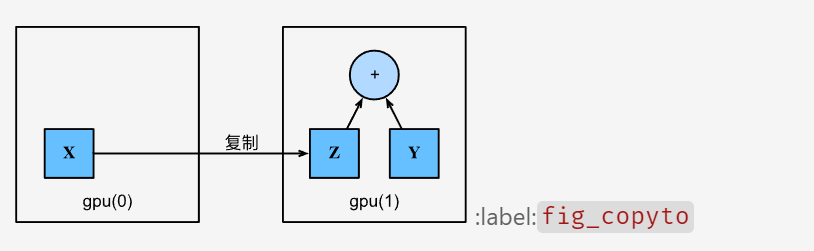

In [12]:
Z = X.cuda(1)
print(X)
print(Z)

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')
tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:1')


现在数据都在同一个GPU上，我们可以将他们相加。

In [13]:
Y + Z

tensor([[1.4067, 1.6026, 1.7900],
        [1.8645, 1.8511, 1.3288]], device='cuda:1')

假设变量`Z`已经存在在第二个GPU上。如果我们还是调用`Z.cuda(1)`会发生什么？他将返回`Z`，而不是复制并分配内存。

In [14]:
Z.cuda(1) is Z

True

## 神经网络与GPU
神经网络模型可以指定设备。下面的代码将模型参数放在GPU上。

In [15]:
net = nn.Sequential(nn.Linear(3,1))
net = net.to(device=try_gpu())

当输入为GPU上的张量时，模型将在同一GPU上计算结果。

In [16]:
net(X)

tensor([[0.1458],
        [0.1458]], device='cuda:0', grad_fn=<AddmmBackward0>)

确认模型参数存储在同一个GPU上。

In [17]:
net[0].weight.data.device

device(type='cuda', index=0)